# Advanced Programming Case Study:
# Sentiment analysis: *Amazon food review*

## Introduction

### 👨‍🎓 Group members 👨‍🎓

* Kaveen Seneviratne
* Shruti Saxena
* Alexis Marin

### Presentation

* The project is based on the Amazon food review from customers dataset
* The dataset contains more than 500K reviews. We will use a sample of 10k reviews

## Dataset

* Contains some product, user, and review information

* Data used here:

    * **Text**: Complete product review by the customer
    * **Summary**: Summary proposed by the customer
    * **Score**: The product rating provided by the customer

### Download the data

https://www.kaggle.com/snap/amazon-fine-food-reviews/download

(254MB)

In [ ]:
import re
from pathlib import Path

import gensim
import gensim.downloader as gensim_api
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import wordcloud
from sklearn import (
    decomposition,
    ensemble,
    feature_extraction,
    linear_model,
    metrics,
    model_selection,
    naive_bayes,
    pipeline,
)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from tqdm.notebook import tqdm
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from plotly.offline import iplot
import plotly.graph_objs as go
from sklearn.manifold import TSNE
import plotly.express as px
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression



In [ ]:
sns.set_style("darkgrid")
sns.set_context("notebook")

nltk.download('punkt')
nltk.download('punkt_tab')
tqdm.pandas()
nltk.download('stopwords')

%config InlineBackend.figure_format="retina"  # For high DPI display

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Exploratory Data Analysis (EDA)

### Read Data

In [ ]:
# Specify the file path
file_path = r"/content/Reviews.csv"

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)
df = df[['Score', 'Summary', 'Text']]
df.head()

,Score,Summary,Text
0,5,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,4,"""Delight"" says it all",This is a confection that has been around a fe...
3,2,Cough Medicine,If you are looking for the secret ingredient i...
4,5,Great taffy,Great taffy at a great price. There was a wid...


### Distribution of the variable ***Score***

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Score    568454 non-null  int64 
 1   Summary  568427 non-null  object
 2   Text     568454 non-null  object
dtypes: int64(1), object(2)
memory usage: 13.0+ MB


In [ ]:
df['Score'] = pd.to_numeric(df['Score'], errors='coerce').fillna(0).astype('int64')


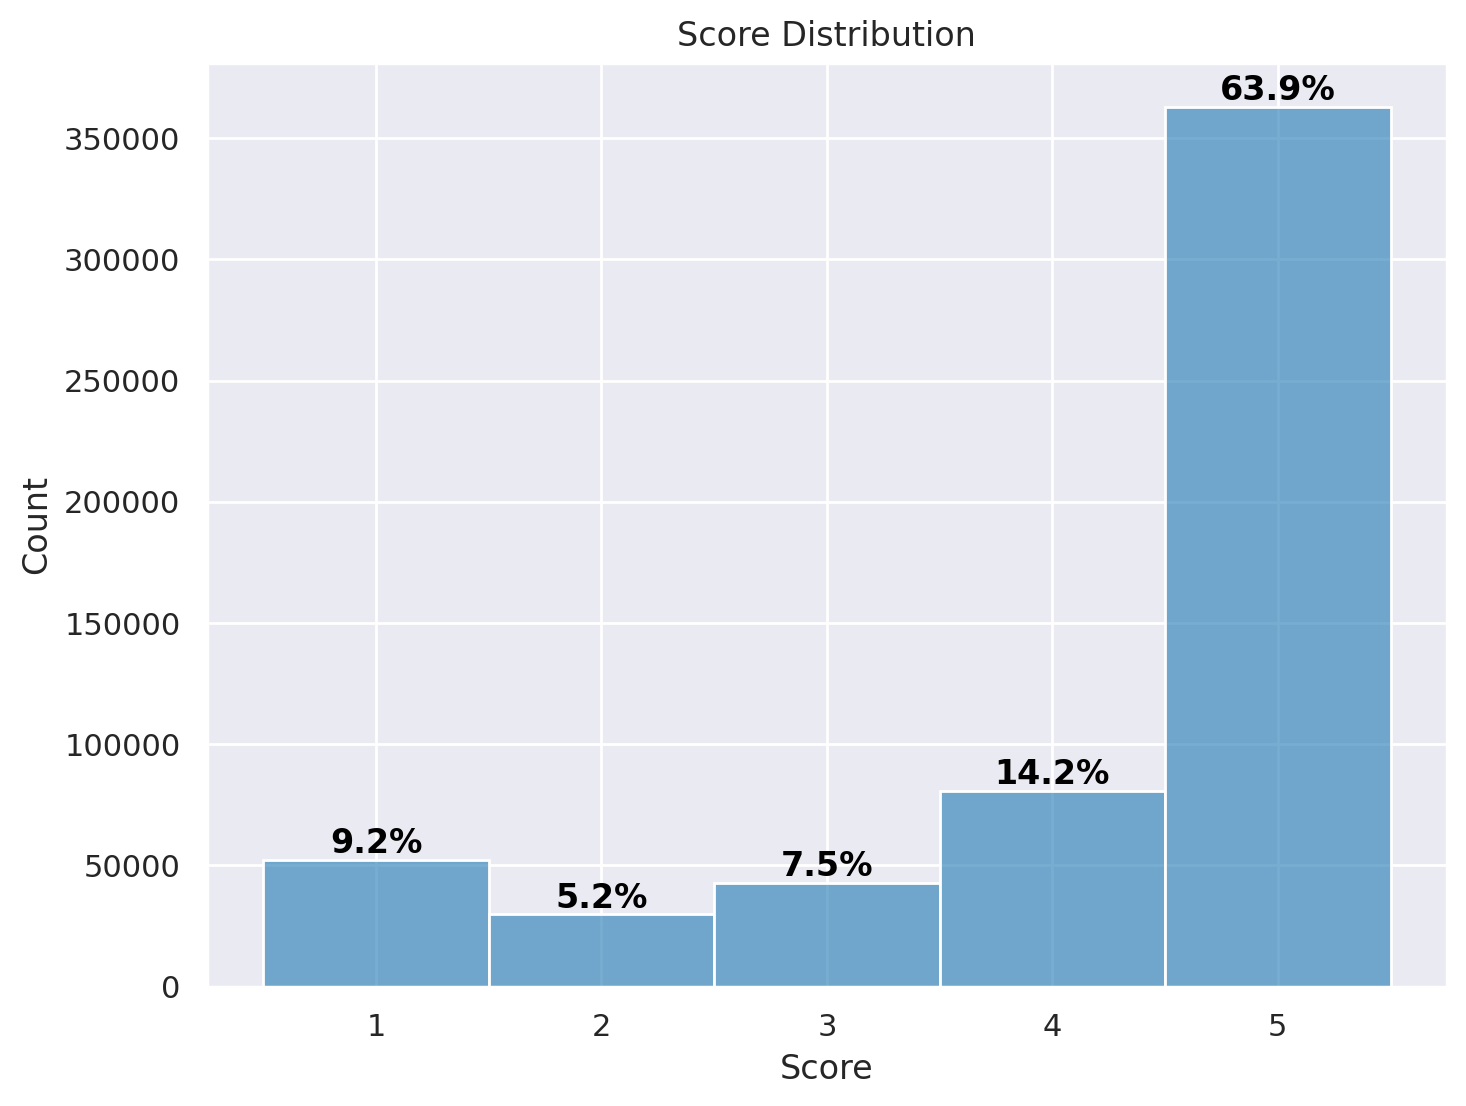

In [ ]:
# Count occurrences of each sentiment
sentiment_counts = df["Score"].value_counts()
total = len(df)  # Total number of samples

# Plot histogram
plt.figure(figsize=(8, 6))
ax = sns.histplot(df, x="Score", alpha=0.6, discrete=True)

# Annotate each bar with the percentage
for p in ax.patches:
    height = p.get_height()  # Get bar height
    percentage = f"{(height / total) * 100:.1f}%"  # Convert to percentage
    ax.annotate(percentage,
                (p.get_x() + p.get_width() / 2, height),  # Position at bar center
                ha="center", va="bottom", fontsize=12, color="black", fontweight="bold")

# Show plot
plt.xlabel("Score")
plt.ylabel("Count")
plt.title("Score Distribution")
plt.show()

In [ ]:
# Number of samples needed
target_size = 10000

# Perform stratified sampling
df_sampled = df.groupby('Score', group_keys=False).apply(lambda x: x.sample(frac=target_size / len(df), random_state=42))

# Save the reduced dataset
# df_sampled.to_csv("Reduced_Reviews.csv", index=False)

# Display the new dataset size and proportions
print(df_sampled['Score'].value_counts(normalize=True))  # Check if proportions are maintained
print(f"New dataset size: {df_sampled.shape}")

Score
5    0.6388
4    0.1419
1    0.0919
3    0.0750
2    0.0524
Name: proportion, dtype: float64
New dataset size: (10000, 3)


<ipython-input-31-ac75a6cfea84>:5: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [ ]:
df = df_sampled.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 348178 to 51941
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Score    10000 non-null  int64 
 1   Summary  10000 non-null  object
 2   Text     10000 non-null  object
dtypes: int64(1), object(2)
memory usage: 312.5+ KB


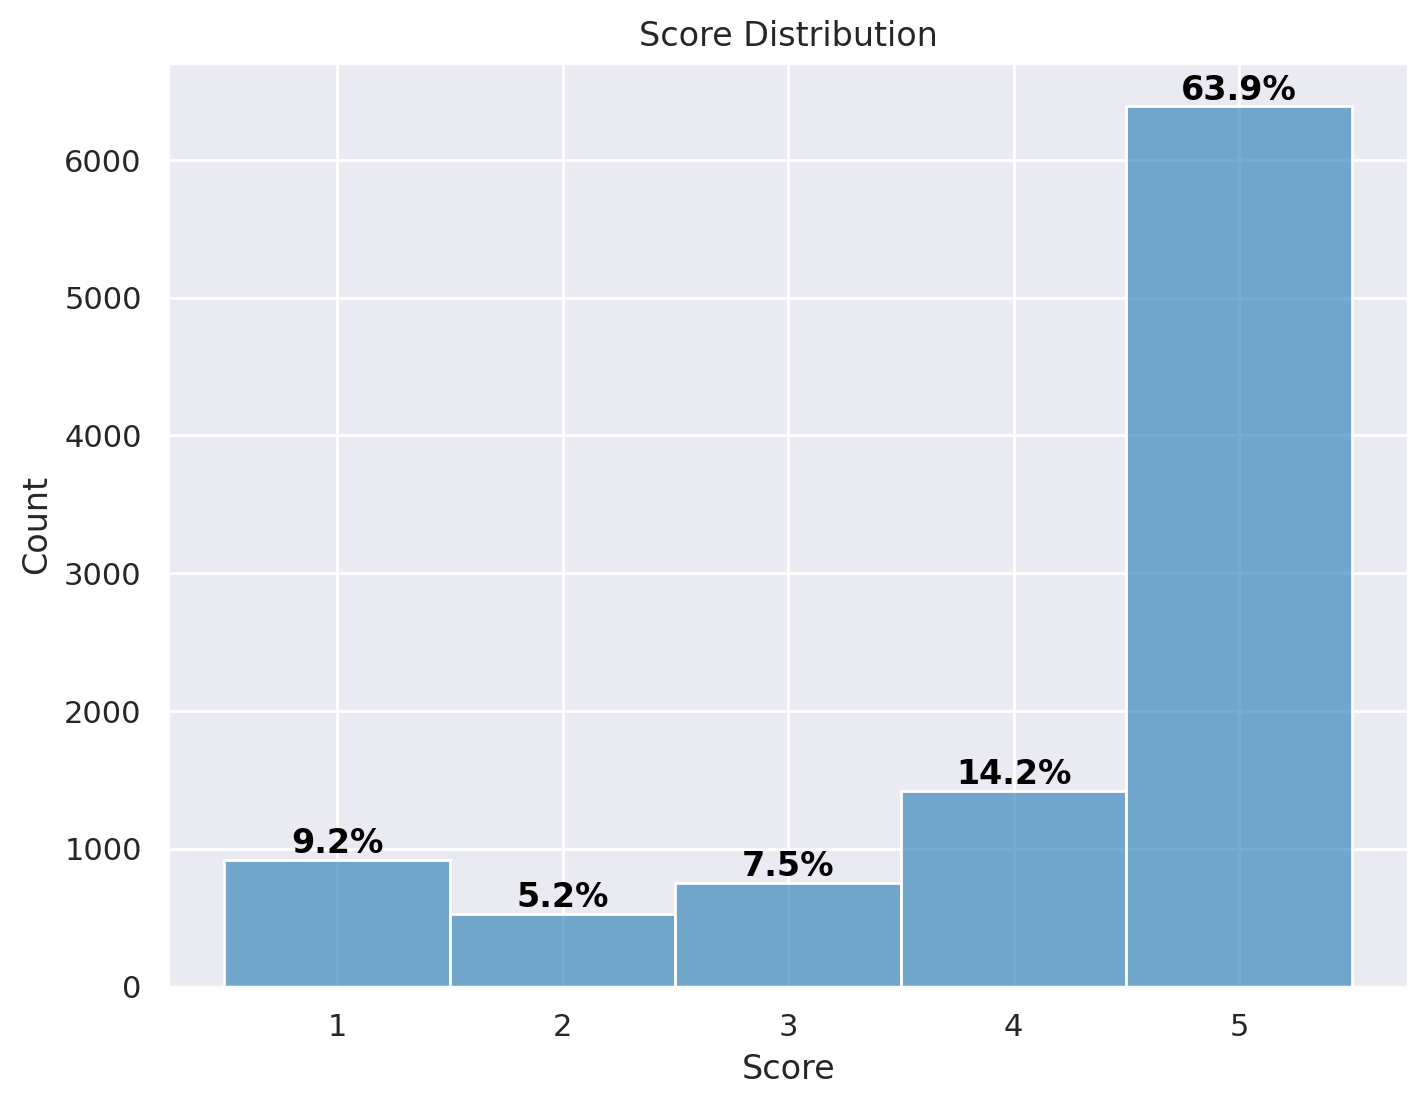

In [ ]:
# Count occurrences of each sentiment
sentiment_counts = df["Score"].value_counts()
total = len(df)  # Total number of samples

# Plot histogram
plt.figure(figsize=(8, 6))
ax = sns.histplot(df, x="Score", alpha=0.6, discrete=True)

# Annotate each bar with the percentage
for p in ax.patches:
    height = p.get_height()  # Get bar height
    percentage = f"{(height / total) * 100:.1f}%"  # Convert to percentage
    ax.annotate(percentage,
                (p.get_x() + p.get_width() / 2, height),  # Position at bar center
                ha="center", va="bottom", fontsize=12, color="black", fontweight="bold")

# Show plot
plt.xlabel("Score")
plt.ylabel("Count")
plt.title("Score Distribution")
plt.show()


* Most of the customer rating is positive

### Analysis of binary and 3-classes versions

* Convert the 5-classes rating in 3-classes sentiment as a target variable
* Positive reviews will be classified as +1, neutral 0, and negative, -1
* The rating value 3 will be used as threshold

In [ ]:
def convert_rating(rating, threshold=3):
    if rating > threshold:
        return 1
    if rating < threshold:
        return -1
    return 0


In [ ]:
df["sentiment"] = df.Score.map(convert_rating)


Histogram of transfromed labels

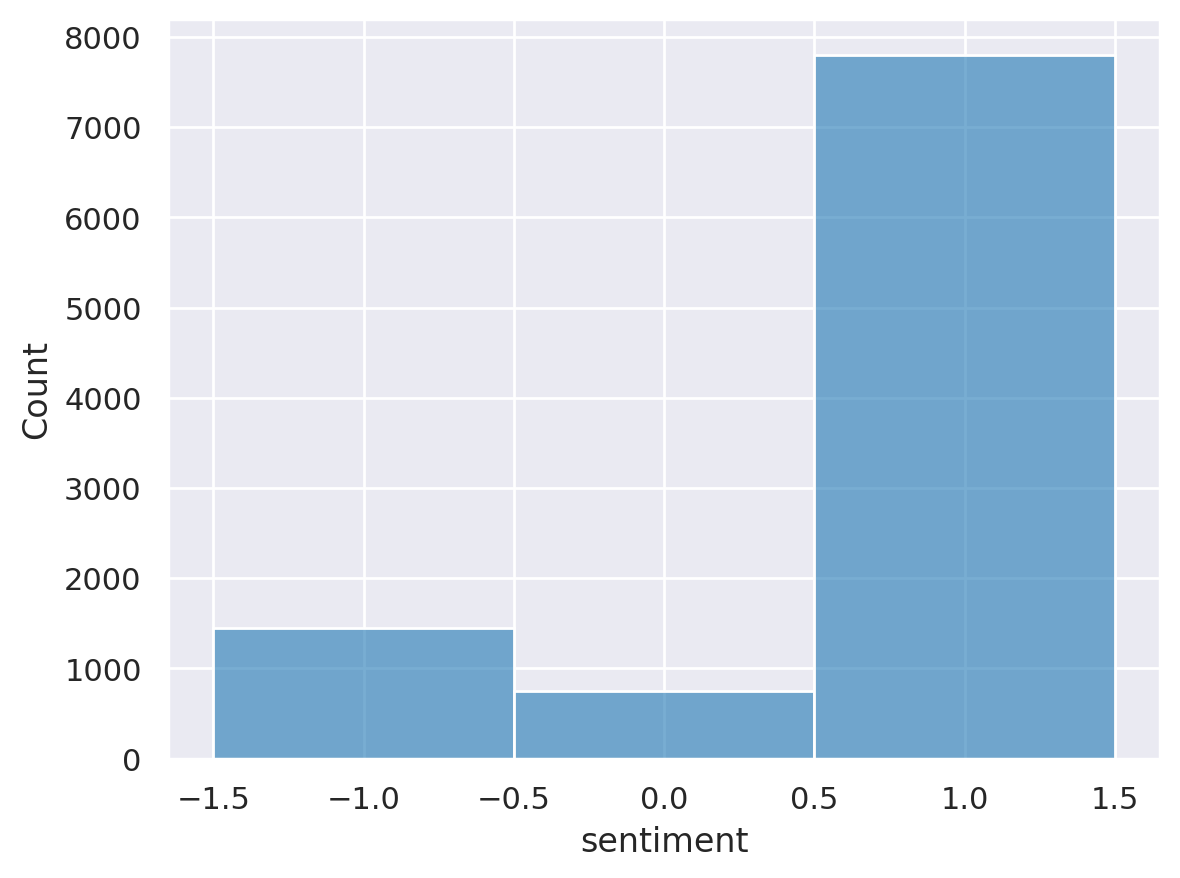

In [ ]:
sns.histplot(df, x="sentiment", alpha=0.6, discrete=True)
plt.show()


### Words distribution

Let's observe the most frequent words for positive and negative reviews through **word clouds**

In [ ]:
# Create stopword list

diff_stopwords = set(wordcloud.STOPWORDS) ^ set(nltk.corpus.stopwords.words("english"))
print(len(diff_stopwords))

stopwords = set(wordcloud.STOPWORDS) | set(nltk.corpus.stopwords.words("english"))
stopwords.update(["br", "href"])

print(len(stopwords))


68
231


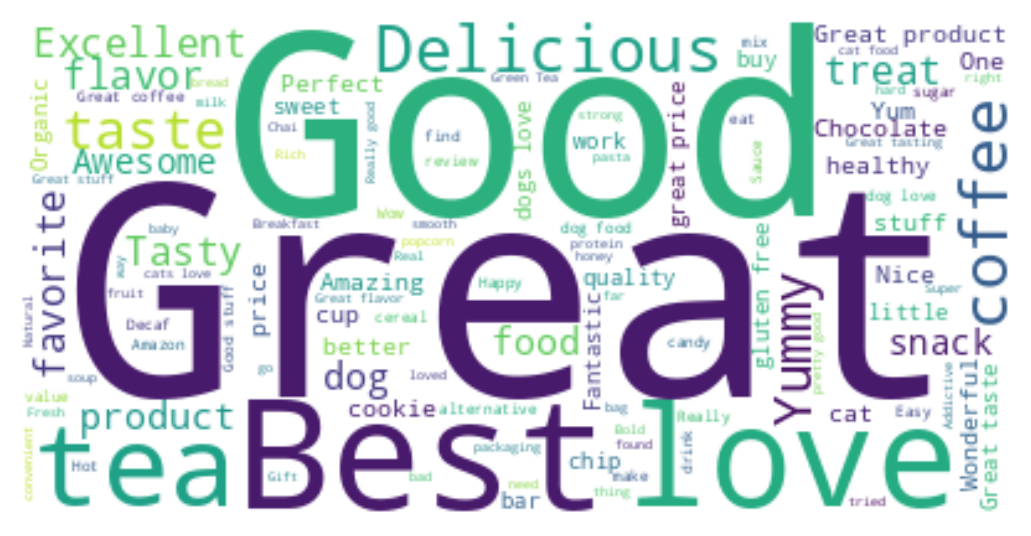

In [ ]:
positive_df = df[df.sentiment == 1]

pos_wordcloud = WordCloud(
    stopwords=stopwords,
    background_color="white",
).generate(" ".join(positive_df.Summary.dropna()))

plt.imshow(pos_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


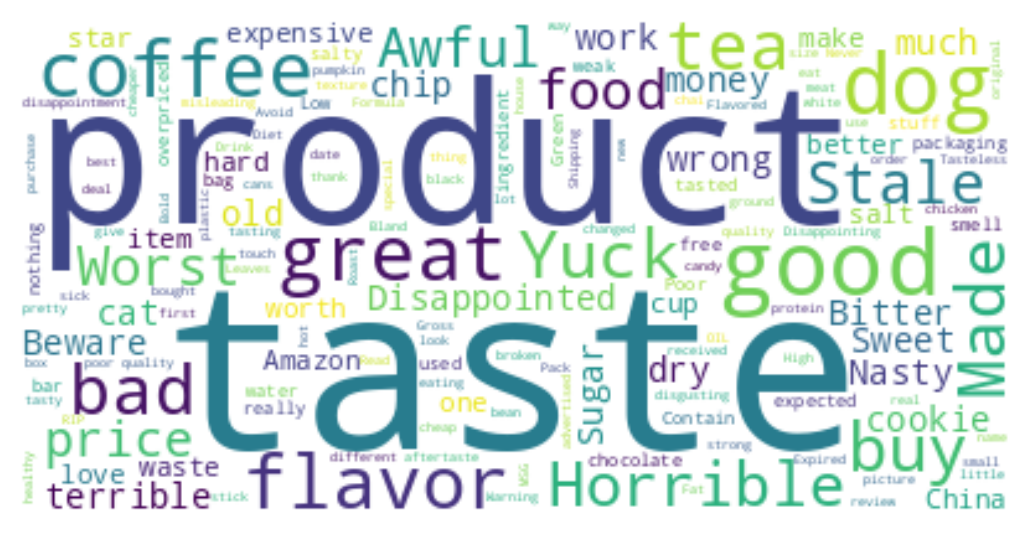

In [ ]:
negative_df = df[df.sentiment == -1]

neg_wordcloud = WordCloud(
    stopwords=stopwords,
    background_color="white",
).generate(" ".join(negative_df.Summary.dropna()))

plt.imshow(neg_wordcloud, interpolation="bilinear")
plt.axis("off")

plt.show()


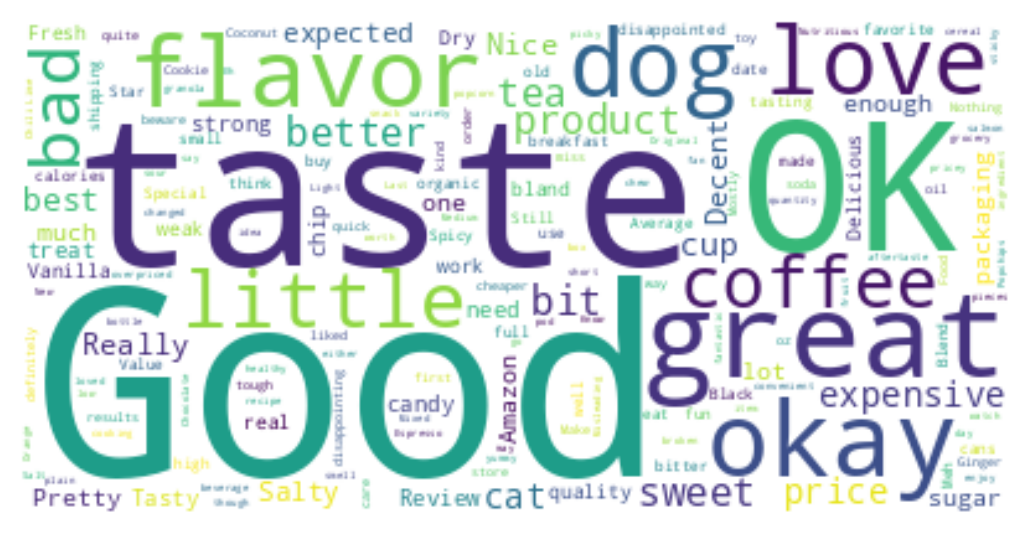

In [ ]:
neutral_df = df[df.sentiment == 0]

neg_wordcloud = WordCloud(
    stopwords=stopwords,
    background_color="white",
).generate(" ".join(neutral_df.Summary.dropna()))

plt.imshow(neg_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


* Positive sentiment words, e.g., *love, best, delicious*

* Negative sentiment words, e.g., *disappointed, bad, yuck*

* The word ***good*** appears in the negative sentiment word cloud, despite being a positive word

    * Probably because it was used in a negative context: ***not good***

* Word **OK** apperas the most in the neutral sentiment word cloud

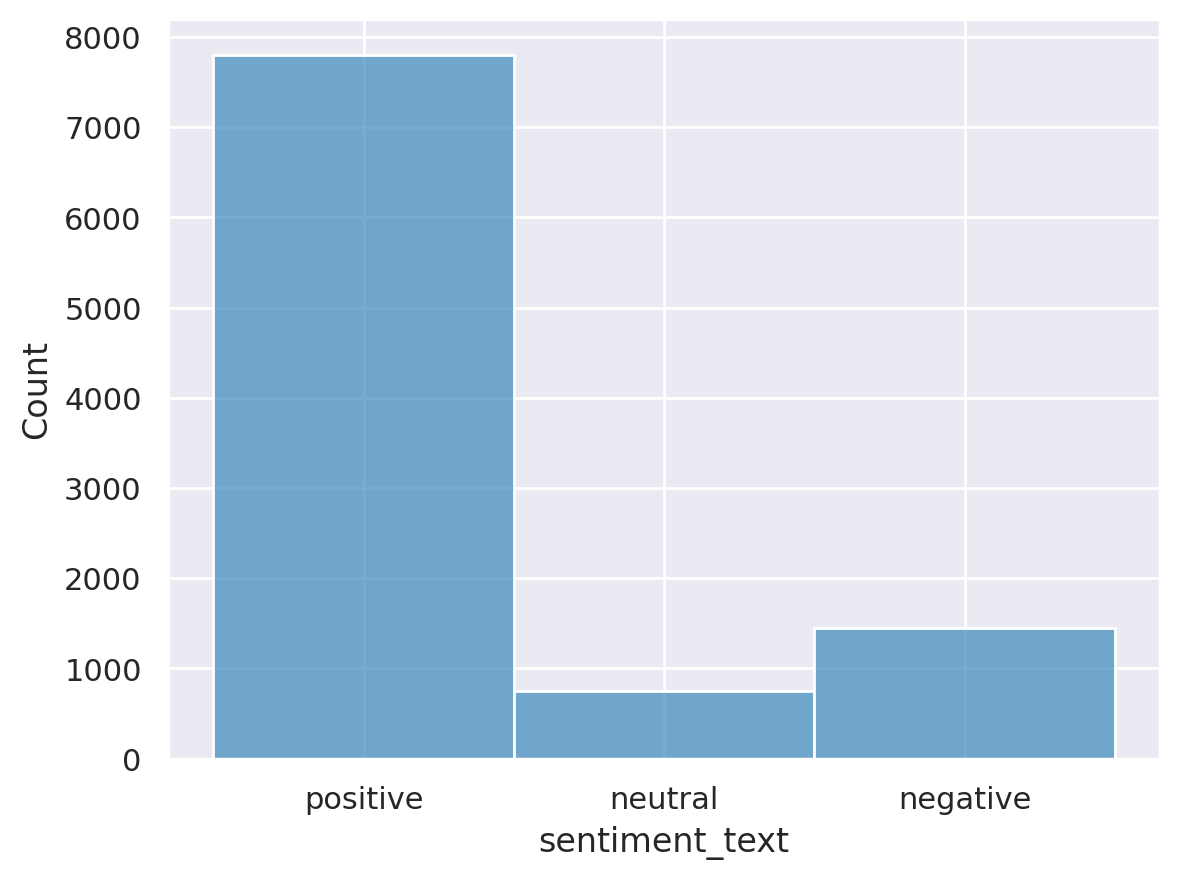

In [ ]:
df["sentiment_text"] = (
    df.sentiment.replace({-1: "negative", 0: "neutral", 1: "positive"})
    .astype("category")  # To set the x-axis order in sns.histplot
    .cat.reorder_categories(["positive", "neutral", "negative"])
)

sns.histplot(
    df,
    x="sentiment_text",
    alpha=0.6,
    discrete=True,
)
plt.show()


## Simple analysis

In [ ]:
df_tokens = df.copy().dropna()
df_tokens["tokens_summary"] = df_tokens["Summary"].map(word_tokenize)
df_tokens["tokens_text"] = df_tokens["Text"].map(word_tokenize)

df_tokens["nb_tokens_summary"] = df_tokens["tokens_summary"].map(len)
df_tokens["nb_tokens_text"] = df_tokens["tokens_text"].map(len)


Average number of words:
 Summary: 4 words
 Text: 95 words
Max number of words:
 Summary: 29 words
 Text: 1981 words


<ipython-input-43-3863af67dd18>:11: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

<ipython-input-43-3863af67dd18>:14: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



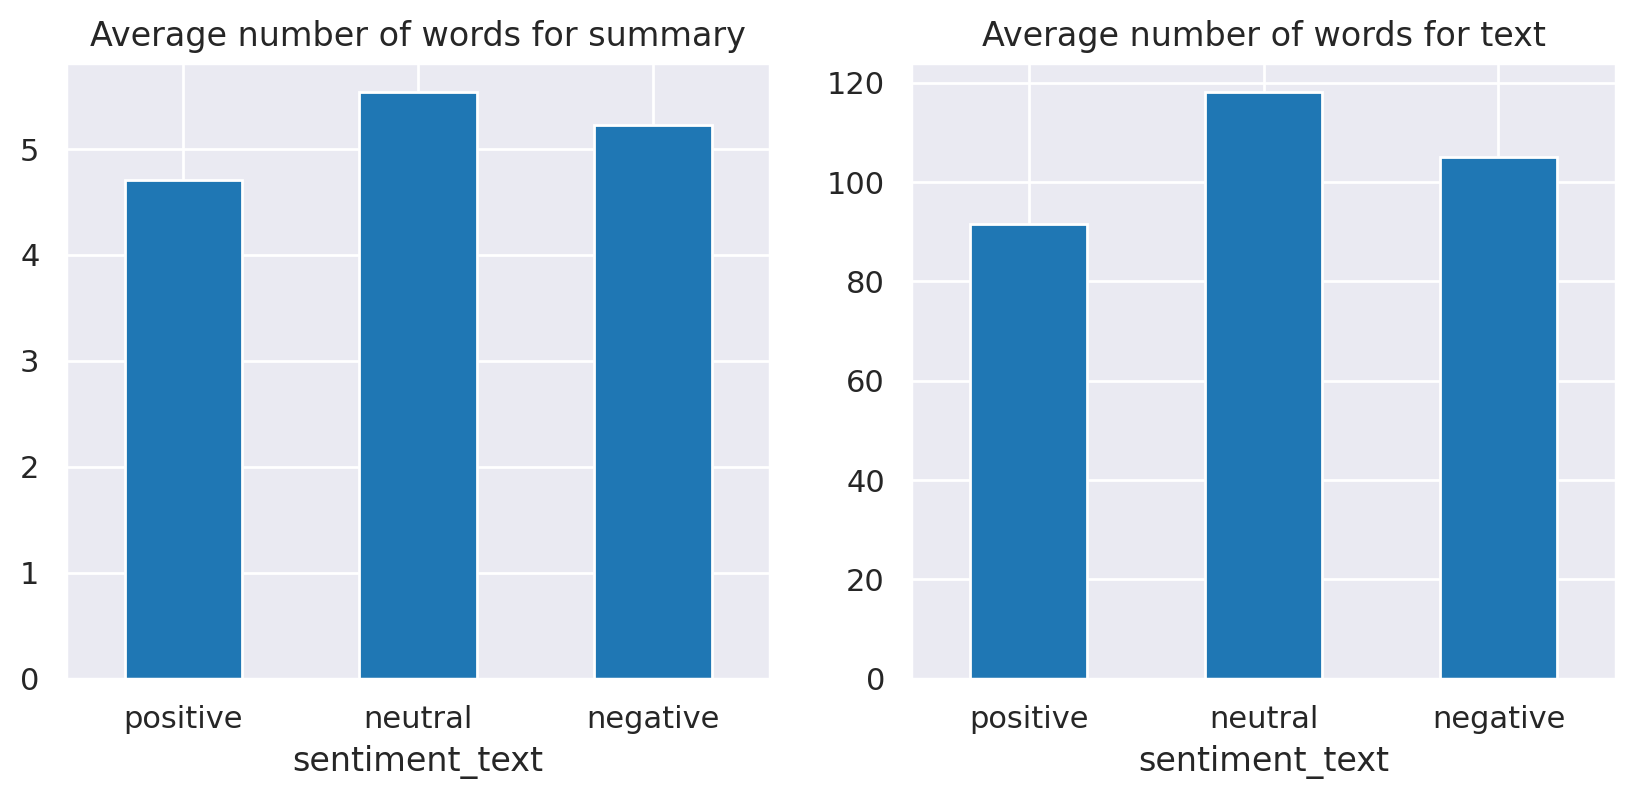

In [ ]:
print(
    f"Average number of words:\n Summary: {int(df_tokens['nb_tokens_summary'].mean())} words\n Text: {int(df_tokens['nb_tokens_text'].mean())} words"
)

print(
    f"Max number of words:\n Summary: {int(df_tokens['nb_tokens_summary'].max())} words\n Text: {int(df_tokens['nb_tokens_text'].max())} words"
)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

df_tokens.groupby("sentiment_text").nb_tokens_summary.mean().plot.bar(
    x="sentiment_text", y="nb_tokens_summary", ax=ax[0], rot=0
)
df_tokens.groupby("sentiment_text").nb_tokens_text.mean().plot.bar(
    x="sentiment_text", y="nb_tokens_text", ax=ax[1], rot=0
)

ax[0].set_title("Average number of words for summary")
ax[1].set_title("Average number of words for text")

plt.show()


In [ ]:
rus = RandomUnderSampler(random_state=1)
df_balanced, y = rus.fit_resample(df_tokens,df_tokens['sentiment_text'])
fig = px.box(df_balanced.sample(n=1000, random_state=1), x="sentiment_text", y="nb_tokens_text", points="all", color="sentiment_text")
fig.show()


## Create the train and test sets

It is **crucial** to keep the **test set** for the very last check when the model has been built, trying different approaches on the **validation set** (you will have to sample out of the training set later).

In [ ]:
train_df, test_df = model_selection.train_test_split(df, test_size=0.2, random_state=1)

In [ ]:
train_df.shape


(8000, 5)

In [ ]:
test_df.shape

(2000, 5)

## Baseline Model with `Summary`

In [ ]:
def evaluate_model(clf, x_valid, y_valid):
    y_pred = clf.predict(x_valid)
    print(classification_report(y_valid, y_pred))

    # Display the confusion matrix.
    disp = metrics.ConfusionMatrixDisplay.from_estimator(
        clf, x_valid, y_valid, cmap=plt.cm.Blues
    )
    disp.figure_.suptitle("Confusion Matrix")
    plt.grid(False)
    plt.show()


Split the data into a train (80%) and validation sets (20%)

In [ ]:
cln_df = train_df[["Summary", "sentiment"]].copy()
cln_df.dropna(subset=["Summary"], inplace=True)

summary_train, summary_valid, y_train, y_valid = model_selection.train_test_split(
    cln_df.Summary, cln_df.sentiment, test_size=0.2, random_state=1
)


### Baseline model with counting based vectorization

In [ ]:
vectorizer = CountVectorizer()

x_train_summary = vectorizer.fit_transform(summary_train)
x_valid_summary = vectorizer.transform(summary_valid)


In [ ]:
x_train_summary

<6400x3955 sparse matrix of type '<class 'numpy.int64'>'
	with 25093 stored elements in Compressed Sparse Row format>

              precision    recall  f1-score   support

          -1       0.62      0.46      0.53       214
           0       0.49      0.19      0.27       126
           1       0.87      0.96      0.91      1260

    accuracy                           0.83      1600
   macro avg       0.66      0.54      0.57      1600
weighted avg       0.80      0.83      0.81      1600



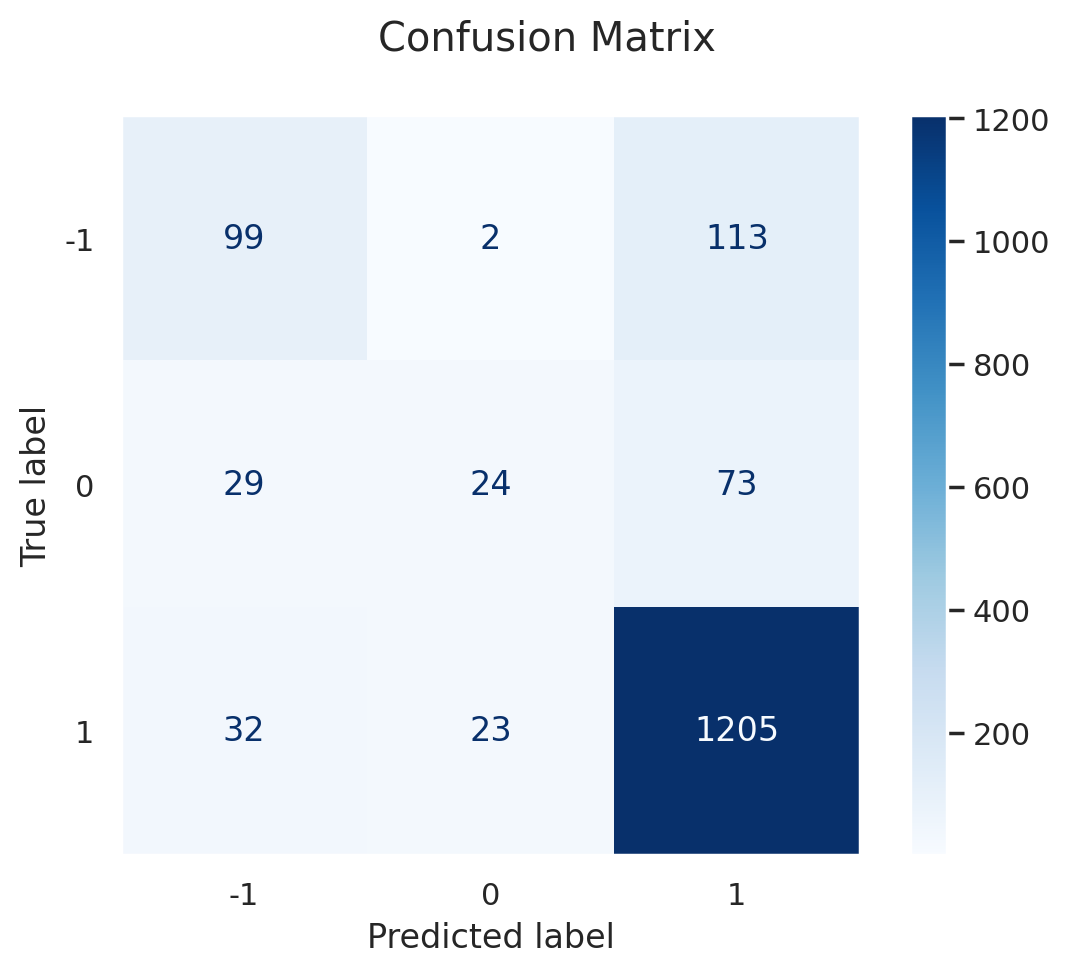

In [ ]:
model = linear_model.SGDClassifier(loss="log_loss")
model.fit(x_train_summary, y_train)
evaluate_model(model, x_valid_summary, y_valid)


We can see that baseline model mostly confused about nutral reviews, they they usually missclassified as positive, less - negative

## TF-IDF


In [ ]:
cln_df = train_df[["Text", "sentiment"]].copy()
cln_df.dropna(subset=["Text"], inplace=True)

text_train, text_valid, y_train, y_valid = model_selection.train_test_split(
    cln_df.Text, cln_df.sentiment, test_size=0.2, random_state=1
)

# count vectorizer:
vectorizer = TfidfVectorizer(stop_words="english")  # token_pattern=r"\b\w+\b"

x_train_tfidf = vectorizer.fit_transform(text_train)
x_valid_tfidf = vectorizer.transform(text_valid)


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

          -1       0.76      0.31      0.44       214
           0       0.00      0.00      0.00       126
           1       0.83      0.99      0.90      1260

    accuracy                           0.82      1600
   macro avg       0.53      0.43      0.45      1600
weighted avg       0.75      0.82      0.77      1600



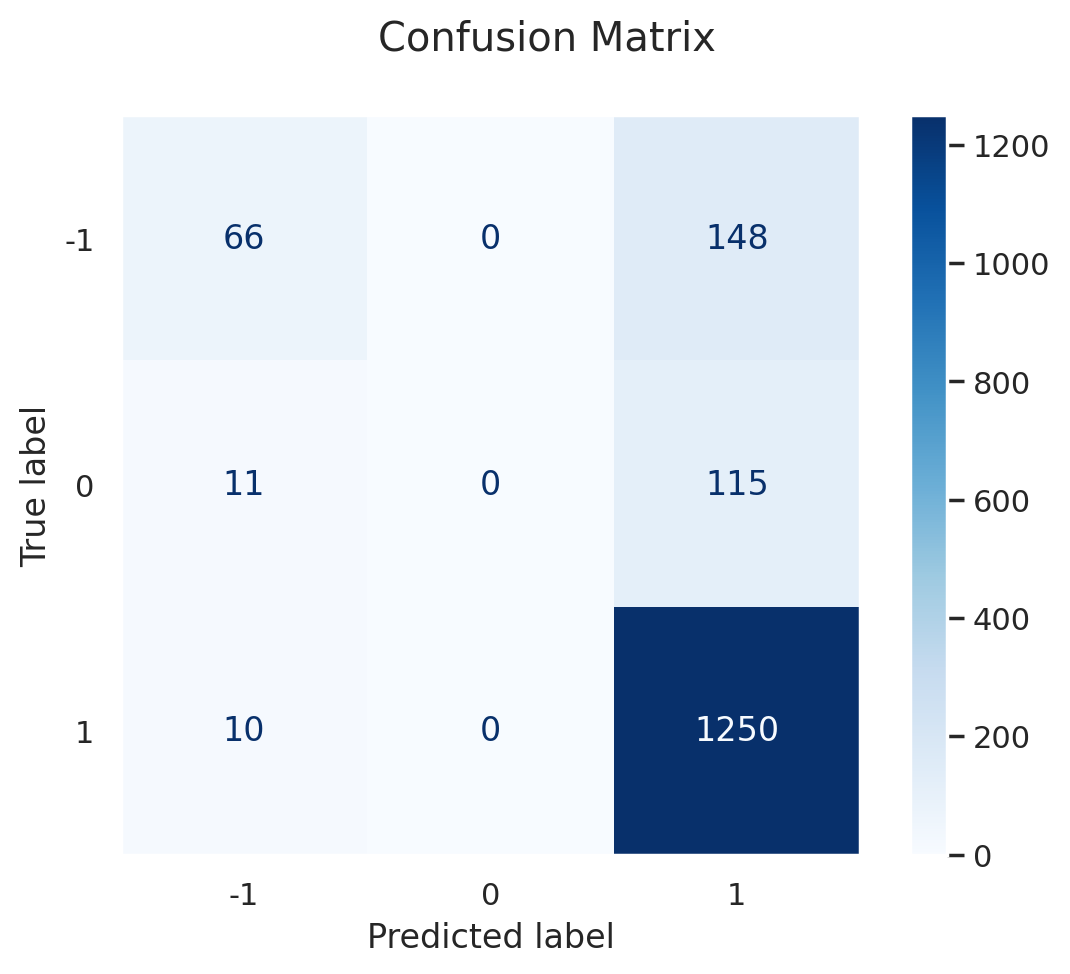

In [ ]:
model = linear_model.SGDClassifier(loss="log_loss")
model.fit(x_train_tfidf, y_train)
evaluate_model(model, x_valid_tfidf, y_valid)


## GloVe embeddings


In [ ]:
WV = gensim_api.load("glove-wiki-gigaword-300")


[========------------------------------------------] 17.9% 67.2/376.1MB downloaded

KeyboardInterrupt: 

In [ ]:
cln_df = train_df[["Text", "sentiment"]].copy()
cln_df.dropna(subset=["Text"], inplace=True)


In [ ]:
def vectorize_sentence_bow(words, wv=WV):
    embeddings = []
    for word in words:
        try:
            embeddings.append(wv[word])
        except KeyError:
            pass
    return np.array(embeddings).mean(axis=0)


### Tokenisation and embeddings (!! slow !!)

In [ ]:
tokenizer_re = re.compile(r"(?u)\b\w\w+\b")  # r"\w+" r"[\w-]+"

cln_df["words"] = cln_df.Text.str.findall(tokenizer_re)
cln_df["embeddings"] = cln_df.words.progress_map(vectorize_sentence_bow)
cln_df.dropna(inplace=True)


Split the data into a train (80%) and test sets (20%)

In [ ]:
x_train_glove, x_valid_glove, y_train, y_valid = model_selection.train_test_split(
    np.stack(cln_df.embeddings),
    cln_df.sentiment,
    test_size=0.2,
    random_state=1,
)


In [ ]:
sgd_glove = linear_model.SGDClassifier(loss="log_loss")
sgd_glove.fit(x_train_glove, y_train)
evaluate_model(sgd_glove, x_valid_glove, y_valid)


---

## Part 2: 🤝 BERT + Sentiment analysis

In [ ]:
from transformers import (
    BertModel,              # Pre-trained BERT model for feature extraction or fine-tuning
    BertTokenizer,          # BERT tokenizer to convert text into input IDs and attention masks
    DistilBertModel,        # Lightweight BERT variant (DistilBERT) for faster performance
    DistilBertTokenizer,    # Tokenizer for DistilBERT
    DistilBertTokenizerFast, # Faster version of the DistilBERT tokenizer
)

import tqdm # For displaying progress bars in loops

import torch                  # Main PyTorch library
import torch.nn as nn         # Neural network modules (e.g., layers, activation functions)
from torch.utils.data import DataLoader  # For batching data during training
import torch.optim as optim   # Optimization algorithms (e.g., Adam, SGD)
import os                     # For file and directory management
from torch.utils.data import Dataset  # Custom dataset creation for PyTorch


This line of code is checking whether a GPU (Graphics Processing Unit) is available and setting the appropriate device for PyTorch operations.

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device


'cuda:0'

distilbert-base-uncased: A lightweight transformer model trained on lowercased English text without case sensitivity (uncased)
- You can switch to the full BERT model by uncommenting this line.
- BERT is more powerful but also heavier and slower compared to DistilBERT.


In [ ]:
model_class, tokenizer_class = DistilBertModel, DistilBertTokenizerFast
pretrained_weights = "distilbert-base-uncased"

## Want BERT instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)
model = model.to(device)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

### Extract features and train simple sentiment classifier

For this code you need GPU with at least 8GB of memory. Use Kaggle or Colab.

In [ ]:
# Extract text and label from the dataframe.
cln_df = train_df[["Text", "sentiment"]].copy()
# Drop rows with missing values.
cln_df.dropna(subset=["Text"], inplace=True)
cln_df.reset_index(drop=True, inplace=True)
cln_df.head(5)


,Text,sentiment
0,I found this coffee bold and flavorful.<br /><...,1
1,My wife loves this stuff and it is hard to fin...,1
2,I keep this on hand for guests who only like l...,1
3,"Of all the brands of Earl Grey, Stash is my fa...",1
4,I love this tea! Not only because it is organi...,1


In [ ]:
cln_df_test = test_df[["Text", "sentiment"]].copy()
cln_df_test.dropna(subset=["Text"], inplace=True)
cln_df_test.reset_index(drop=True, inplace=True)
cln_df_test.head(5)


,Text,sentiment
0,I should say...my dogs love these! I like the ...,1
1,I have also tried the regular Lowrey's microwa...,1
2,This gluten free pizza is easy to make and has...,1
3,"Best lollipops I've ever tasted, you can tell ...",1
4,My wife and I really enjoyed the apple and oth...,1


In [ ]:
## Split to train and validation sets.
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(
    cln_df.Text,
    cln_df.sentiment,
    test_size=0.2,
    random_state=1,
)


In [ ]:
x_test, y_test = cln_df_test.Text, cln_df_test.sentiment

In [ ]:
## Here we take only 30% of train and validation data, to make embeddins extraction faster.
PERCENTAGE_SIZE = 1
BATCH_SIZE = 250


In [ ]:
# Take 30% to reduce computation time.
train_chunks = [
    x_train[i : i + BATCH_SIZE]
    for i in range(0, int(x_train.shape[0] * PERCENTAGE_SIZE), BATCH_SIZE)
]
valid_chunks = [
    x_valid[i : i + BATCH_SIZE]
    for i in range(0, int(x_valid.shape[0] * PERCENTAGE_SIZE), BATCH_SIZE)
]
test_chunks = [
    x_test[i : i + BATCH_SIZE] for i in range(0, int(x_test.shape[0]), BATCH_SIZE)
]


In [ ]:
# Take 30% of labels
y_train_chunks = [
    y_train[i : i + BATCH_SIZE]
    for i in range(0, int(y_train.shape[0] * PERCENTAGE_SIZE), BATCH_SIZE)
]
y_valid_chunks = [
    y_valid[i : i + BATCH_SIZE]
    for i in range(0, int(y_valid.shape[0] * PERCENTAGE_SIZE), BATCH_SIZE)
]
y_test_chunks = [
    y_test[i : i + BATCH_SIZE] for i in range(0, int(y_test.shape[0]), BATCH_SIZE)
]

y_train_chunks = np.concatenate(y_train_chunks)
y_valid_chunks = np.concatenate(y_valid_chunks)
y_test_chunks = np.concatenate(y_test_chunks)


Extract train data features

In [ ]:
train_features = []
# list_input_ids = []
# list_attention_mask = []
for chunk in tqdm.tqdm(train_chunks):
    tok_text = tokenizer.batch_encode_plus(
        chunk.tolist(),
        add_special_tokens=True,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_tensors="pt",
    )

    # list_input_ids.append(tok_text["input_ids"])
    # list_attention_mask.append(tok_text["attention_mask"])
    # Remove token_type_ids to avoid the error
    if "token_type_ids" in tok_text:
        del tok_text["token_type_ids"]
    tok_text = tok_text.to(device)
    with torch.no_grad():
        last_hidden_states = model(**tok_text)

    features = last_hidden_states[0][:, 0, :].cpu().numpy()
    train_features.append(features)


train_features = np.concatenate(train_features)
# list_input_ids = np.concatenate(list_input_ids)
# list_attention_mask = np.concatenate(list_attention_mask)
train_features.shape


100%|██████████| 26/26 [01:27<00:00,  3.36s/it]


(6400, 768)

Extract validation data features

In [ ]:
valid_features = []
# list_input_ids = []
# list_attention_mask = []
for chunk in tqdm.tqdm(valid_chunks):
    tok_text = tokenizer.batch_encode_plus(
        chunk.tolist(),
        add_special_tokens=True,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_tensors="pt",
    )
    # Remove token_type_ids to avoid the error
    if "token_type_ids" in tok_text:
        del tok_text["token_type_ids"]
    tok_text = tok_text.to(device)
    with torch.no_grad():
        last_hidden_states = model(**tok_text)

    features = last_hidden_states[0][:, 0, :].cpu().numpy()
    valid_features.append(features)


valid_features = np.concatenate(valid_features)
# list_input_ids = np.concatenate(list_input_ids)
# list_attention_mask = np.concatenate(list_attention_mask)
valid_features.shape


100%|██████████| 7/7 [00:22<00:00,  3.22s/it]


(1600, 768)

... and test set

In [ ]:
test_features = []
# list_input_ids = []
# list_attention_mask = []
for chunk in tqdm.tqdm(test_chunks):
    tok_text = tokenizer.batch_encode_plus(
        chunk.tolist(),
        add_special_tokens=True,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_tensors="pt",
    )
    # Remove token_type_ids to avoid the error
    if "token_type_ids" in tok_text:
        del tok_text["token_type_ids"]
    tok_text = tok_text.to(device)
    with torch.no_grad():
        last_hidden_states = model(**tok_text)

    features = last_hidden_states[0][:, 0, :].cpu().numpy()
    test_features.append(features)


test_features = np.concatenate(test_features)
# list_input_ids = np.concatenate(list_input_ids)
# list_attention_mask = np.concatenate(list_attention_mask)
test_features.shape


100%|██████████| 8/8 [00:28<00:00,  3.61s/it]


(2000, 768)

Save them in numpy data format

In [ ]:
np.save("train_features.npy", train_features)
np.save("valid_features.npy", valid_features)
np.save("test_features.npy", test_features)


## Train classification models

### Load embeddings

In [ ]:
# load train and validation features
train_features = np.load("train_features.npy")
valid_features = np.load("valid_features.npy")
test_features = np.load("test_features.npy")

# Here you have to change the directory of the files
train_features_summary = np.load("/content/train_features.npy")
valid_features_summary = np.load("/content/train_features.npy")
test_features_summary = np.load("/content/test_features.npy")


#### Logistic regression

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



              precision    recall  f1-score   support

          -1       0.62      0.64      0.63       214
           0       0.35      0.17      0.23       126
           1       0.90      0.94      0.92      1260

    accuracy                           0.84      1600
   macro avg       0.62      0.58      0.59      1600
weighted avg       0.82      0.84      0.83      1600



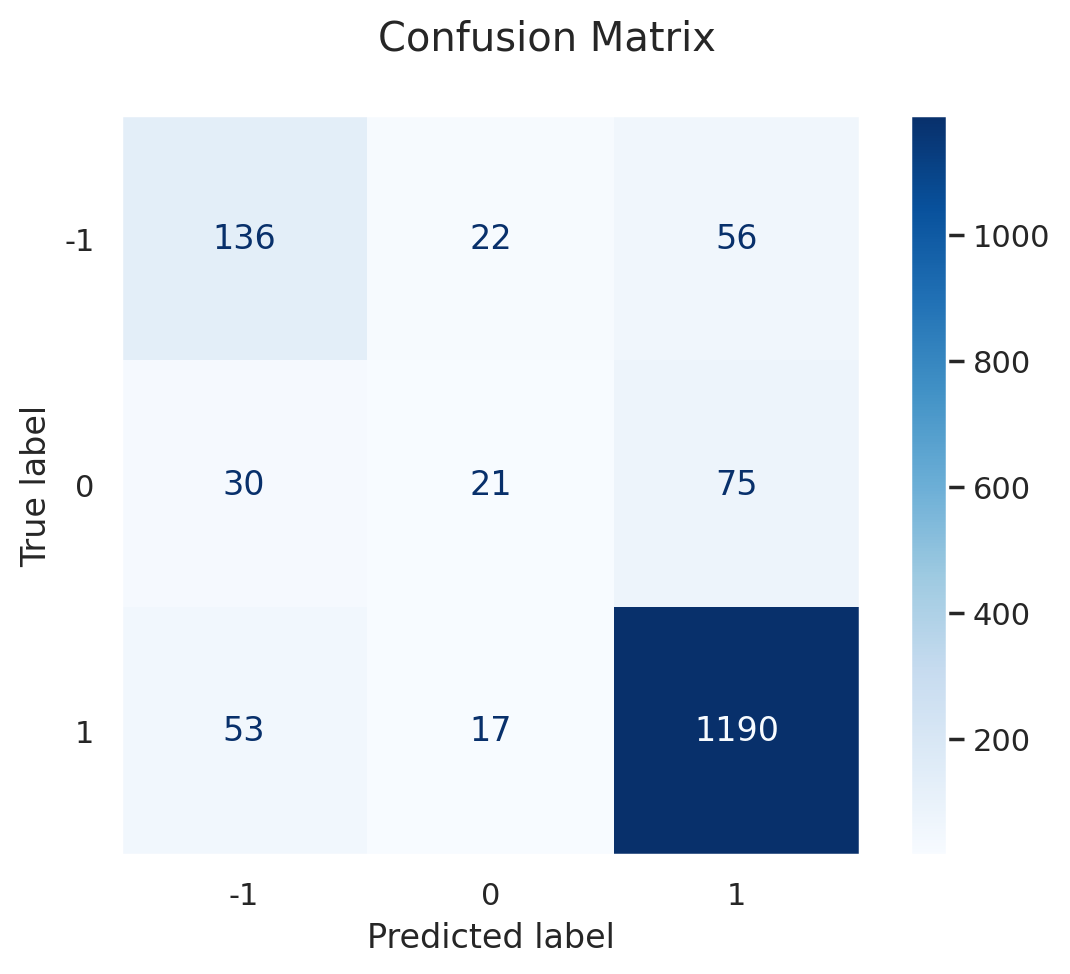

In [ ]:
## Train a model on the training features.

train_features = train_features.reshape(train_features.shape[0], -1)
valid_features = valid_features.reshape(valid_features.shape[0], -1)

clf_bert_logistic_text = LogisticRegression(
    solver="lbfgs", multi_class="multinomial", max_iter=100
)
clf_bert_logistic_text.fit(train_features, y_train_chunks)
evaluate_model(clf_bert_logistic_text, valid_features, y_valid_chunks)


#### SGDClassifier

In [ ]:
clf_bert_sgd = linear_model.SGDClassifier()
clf_bert_sgd.fit(train_features, y_train_chunks)


SGDClassifier()

In [ ]:
from sklearn.metrics import classification_report

preds = clf_bert_sgd.predict(valid_features)
print(classification_report(y_valid_chunks, preds))


              precision    recall  f1-score   support

          -1       0.69      0.61      0.65       214
           0       0.33      0.25      0.28       126
           1       0.91      0.95      0.93      1260

    accuracy                           0.85      1600
   macro avg       0.64      0.60      0.62      1600
weighted avg       0.83      0.85      0.84      1600



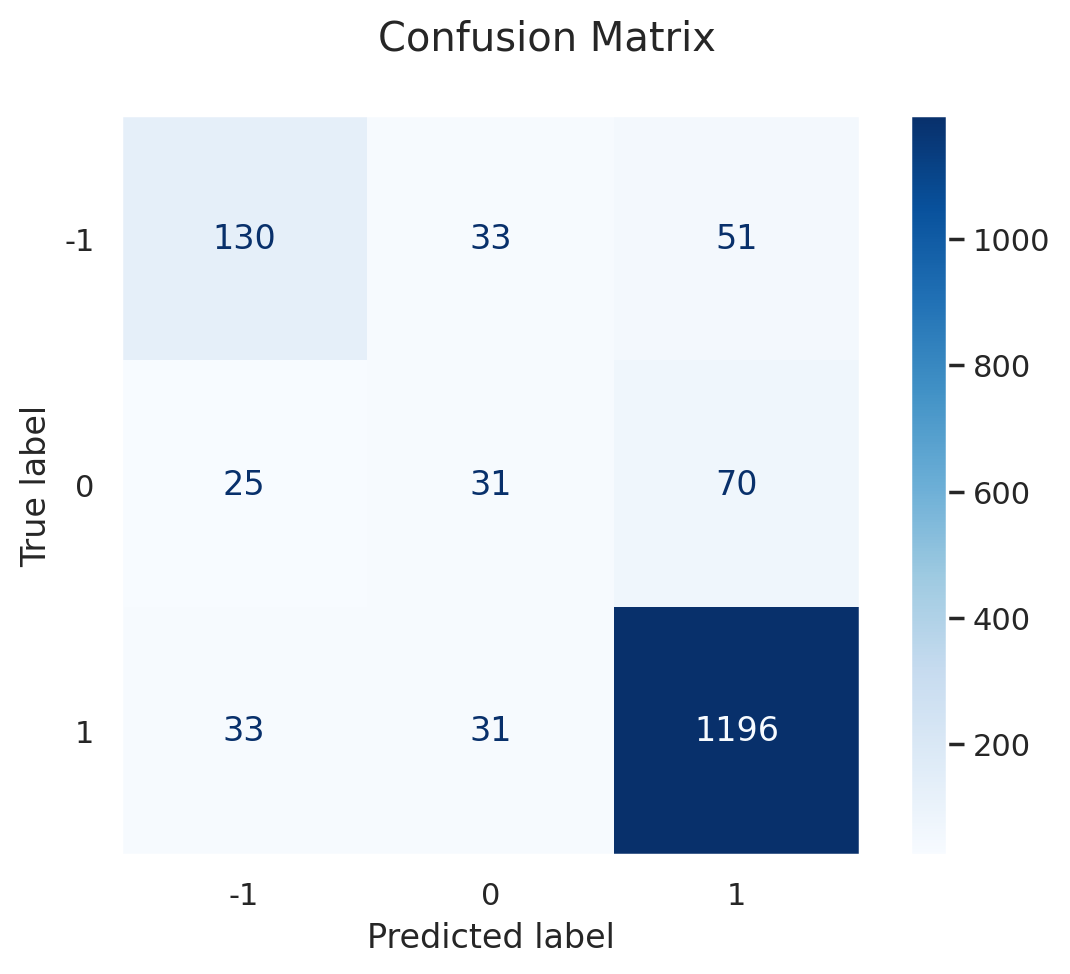

In [ ]:
disp = metrics.ConfusionMatrixDisplay.from_estimator(
    clf_bert_sgd, valid_features, y_valid_chunks, cmap=plt.cm.Blues
)
disp.figure_.suptitle("Confusion Matrix")
plt.grid(False)
plt.show()


#### PCA dimensionality reduction + RandomForest

In [ ]:
# Reduce dimensionality with PCA. Reduce train and validation features.
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA


Firsly, we tried different n_components for PCA dimensionality reduction. Then, we chose the best one with the best f1-score and trained bigger RandomForest model.

In [ ]:
# For different n_components of PCA, train and validate the model.
f1_scores = []
pca_components = [30, 50, 100, 200, 400, 500, 600, 768]
clf_bert_tree = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=0)
for i in pca_components:
    pca = PCA(n_components=i)
    pca.fit(train_features)

    train_features_pca = pca.transform(train_features)
    valid_features_pca = pca.transform(valid_features)

    clf_bert_tree.fit(train_features_pca, y_train_chunks)

    preds = clf_bert_tree.predict(valid_features_pca)
    print(f1_score(y_valid_chunks, preds, average="macro"))

    f1_scores.append(f1_score(y_valid_chunks, preds, average="macro"))


0.4522626616597652
0.41791150197321086
0.3750987039403244
0.3403131990659866
0.3276826687336418
0.3278941883593046
0.32066999071531255
0.32846529485228115


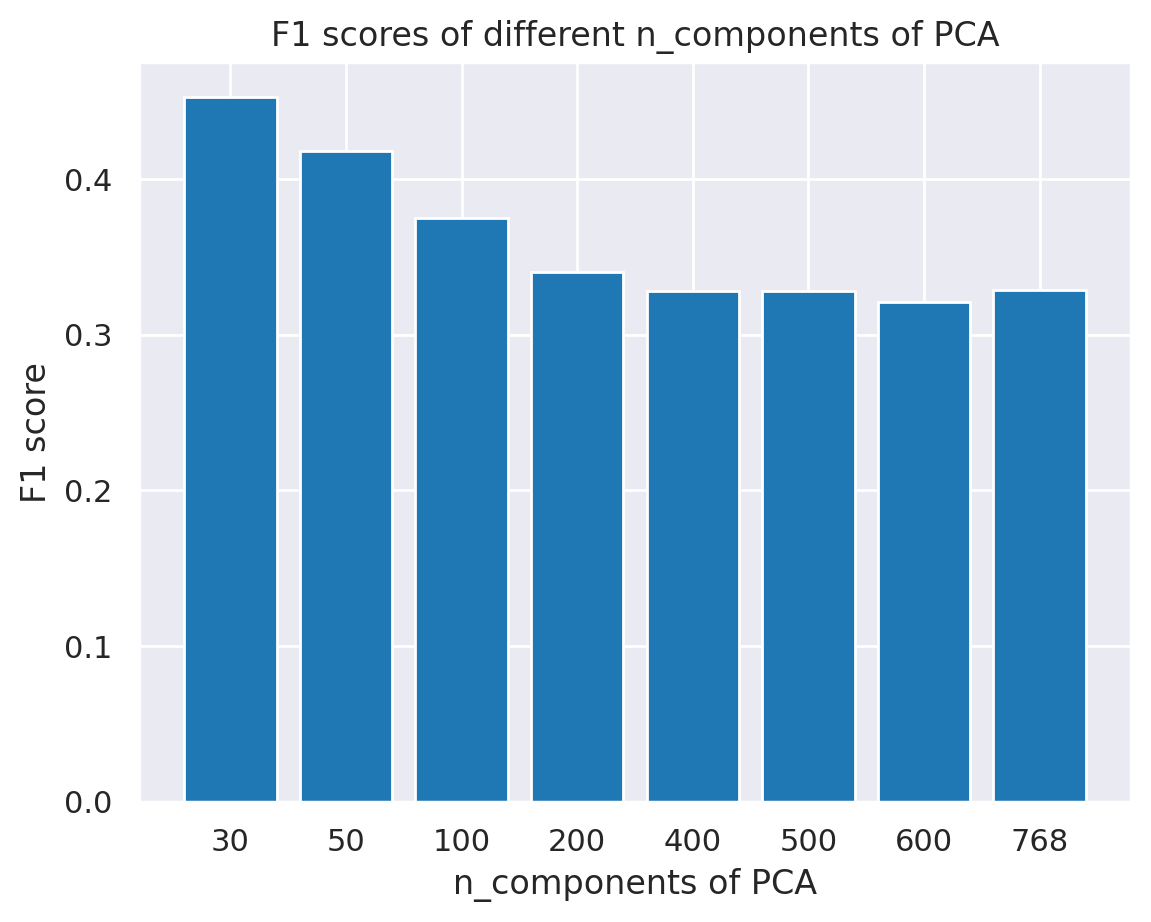

In [ ]:
# plot f1_scores bar plot
plt.bar(range(len(f1_scores)), f1_scores)
plt.xticks(range(len(f1_scores)), pca_components)
plt.title("F1 scores of different n_components of PCA")
plt.xlabel("n_components of PCA")
plt.ylabel("F1 score")
plt.grid(True)
plt.show()


Train on the best n_components value

              precision    recall  f1-score   support

          -1       0.76      0.35      0.47       214
           0       0.80      0.03      0.06       126
           1       0.84      0.99      0.91      1260

    accuracy                           0.83      1600
   macro avg       0.80      0.46      0.48      1600
weighted avg       0.82      0.83      0.78      1600

PCA Explained variance ratio: 0.7091346979141235


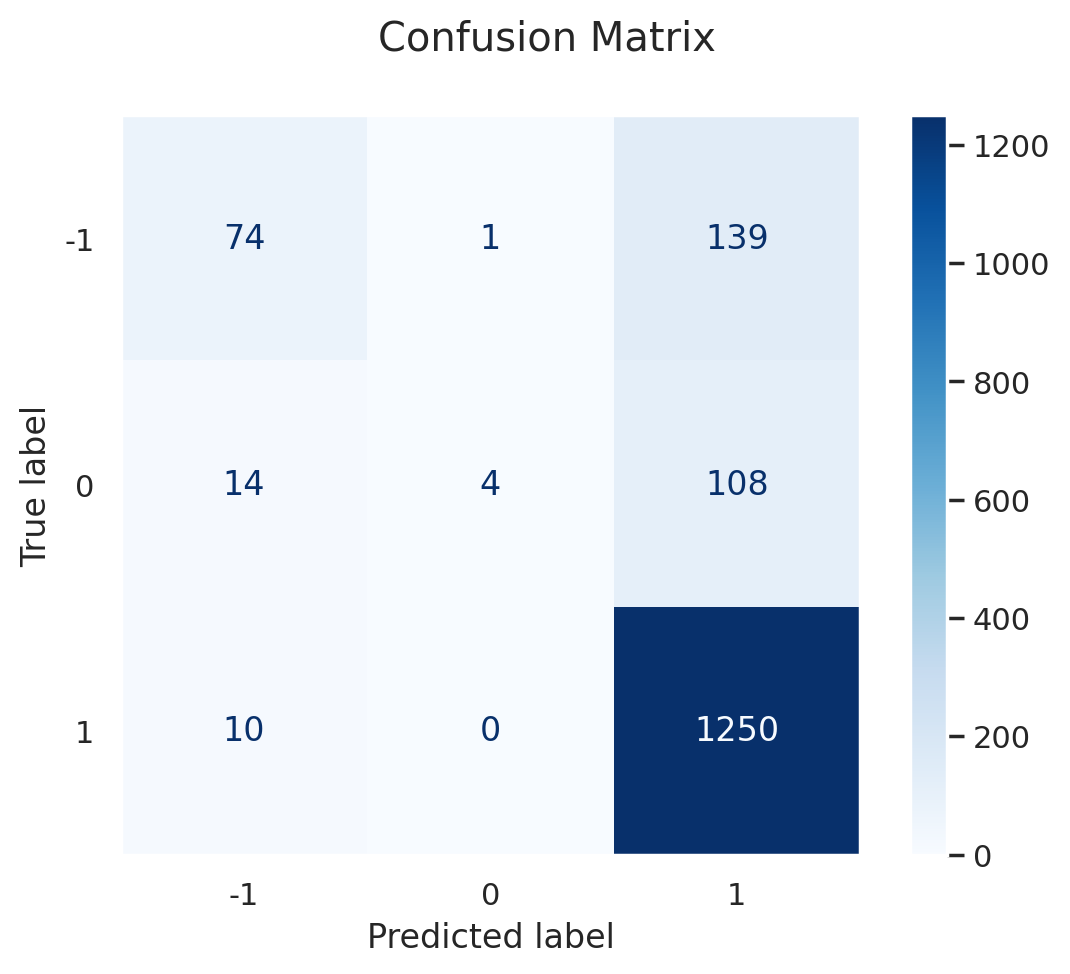

In [ ]:
pca = PCA(n_components=30)

pca.fit(train_features)

train_features_pca = pca.transform(train_features)
valid_features_pca = pca.transform(valid_features)

# Train a  Random Forest model on the reduced features.
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=500, max_features=20, random_state=0)

# Fit the model on the reduced features.
clf.fit(train_features_pca, y_train_chunks)

## Create classification report
from sklearn.metrics import classification_report

preds = clf.predict(valid_features_pca)
print(classification_report(y_valid_chunks, preds))
print("PCA Explained variance ratio: {}".format(np.sum(pca.explained_variance_ratio_)))

# Display the confusion matrix.
disp = metrics.ConfusionMatrixDisplay.from_estimator(
    clf, valid_features_pca, y_valid_chunks, cmap=plt.cm.Blues
)

disp.figure_.suptitle("Confusion Matrix")
plt.grid(False)
plt.show()


## Back to logistic regression

Increase the max number of estimators to 2000

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



              precision    recall  f1-score   support

          -1       0.64      0.65      0.65       214
           0       0.35      0.14      0.20       126
           1       0.90      0.95      0.93      1260

    accuracy                           0.85      1600
   macro avg       0.63      0.58      0.59      1600
weighted avg       0.82      0.85      0.83      1600



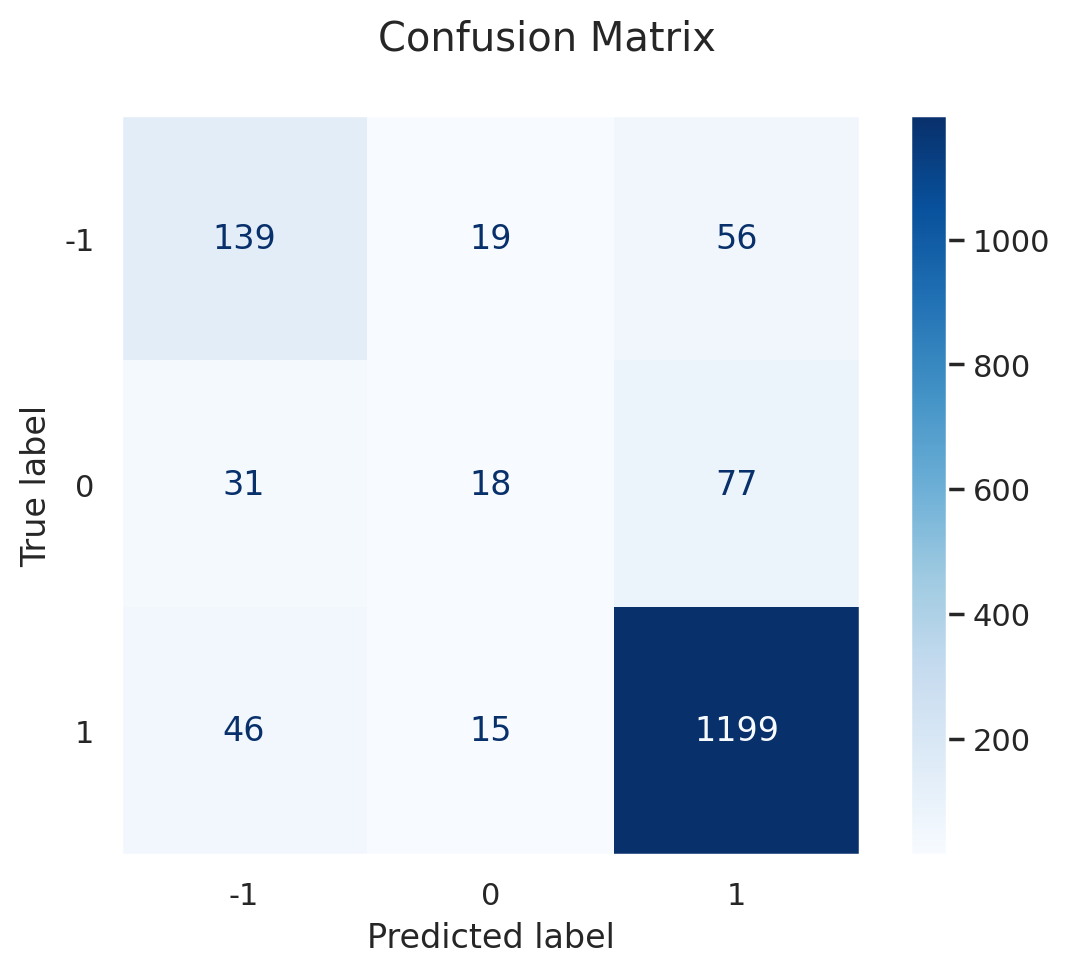

In [ ]:
train_features = train_features.reshape(train_features.shape[0], -1)
valid_features = valid_features.reshape(valid_features.shape[0], -1)

clf_bert_logistic_text = LogisticRegression(
    solver="lbfgs", multi_class="multinomial", max_iter=2000
)
clf_bert_logistic_text.fit(train_features, y_train_chunks)
evaluate_model(clf_bert_logistic_text, valid_features, y_valid_chunks)


### Try with the summary

In [ ]:
print(f"valid_features_summary shape: {valid_features_summary.shape}")
print(f"y_valid_chunks shape: {len(y_valid_chunks)}")

# Check if you accidentally reshaped data incorrectly
if valid_features_summary.shape[0] != len(y_valid_chunks):
    valid_features_summary = valid_features_summary[:len(y_valid_chunks)]  # Trim excess


valid_features_summary shape: (6400, 768)
y_valid_chunks shape: 1600


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



              precision    recall  f1-score   support

          -1       0.12      0.12      0.12       214
           0       0.10      0.05      0.06       126
           1       0.79      0.83      0.81      1260

    accuracy                           0.68      1600
   macro avg       0.34      0.33      0.33      1600
weighted avg       0.65      0.68      0.66      1600



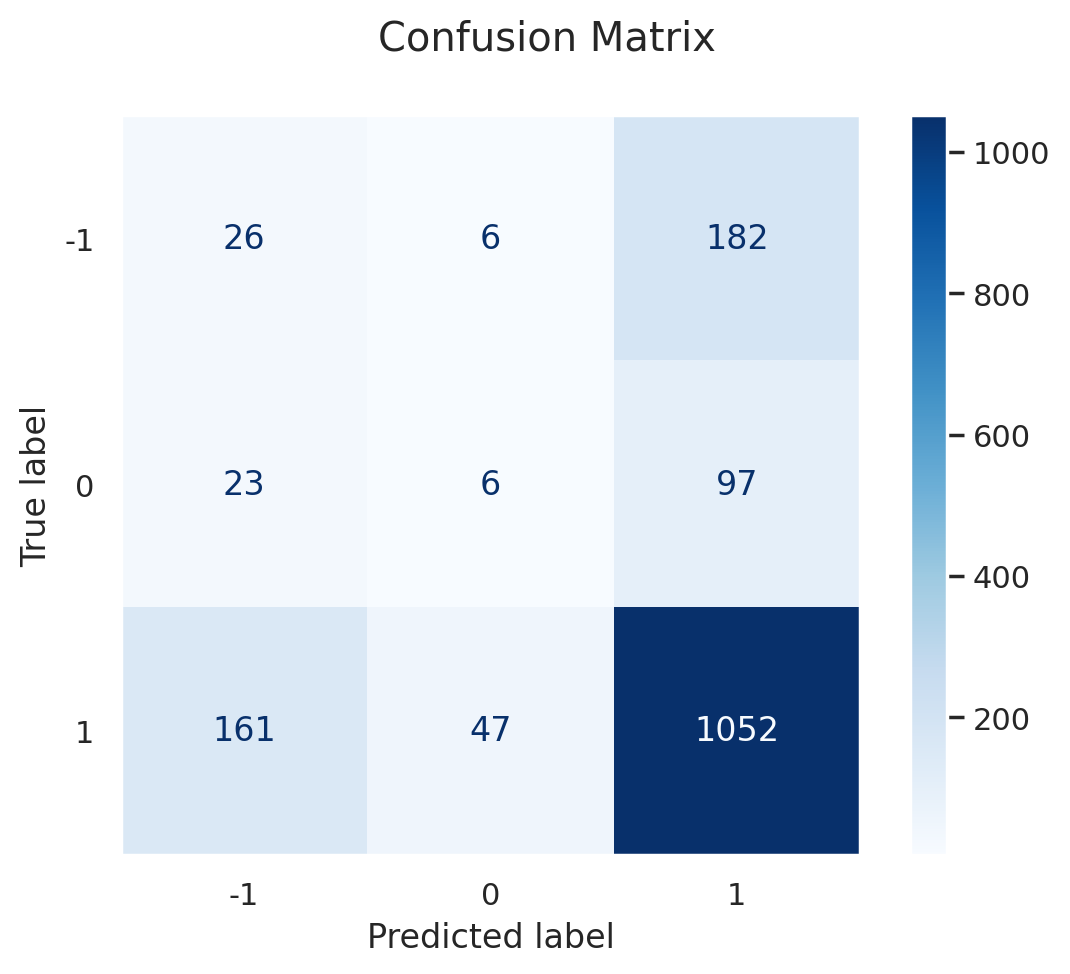

In [ ]:
#

clf_bert_logistic_summary = LogisticRegression(
    solver="lbfgs", multi_class="multinomial", max_iter=200
)
clf_bert_logistic_summary.fit(train_features_summary, y_train_chunks)
evaluate_model(clf_bert_logistic_summary, valid_features_summary, y_valid_chunks)


### Stack both summary and text

In [ ]:
train_stacked = np.concatenate([train_features_summary,train_features],axis=1)
valid_stacked = np.concatenate([valid_features_summary,valid_features],axis=1)

print(train_stacked.shape,valid_stacked.shape)

(6400, 1536) (1600, 1536)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



              precision    recall  f1-score   support

          -1       0.46      0.21      0.28       214
           0       0.29      0.04      0.07       126
           1       0.82      0.97      0.89      1260

    accuracy                           0.79      1600
   macro avg       0.53      0.41      0.41      1600
weighted avg       0.73      0.79      0.74      1600



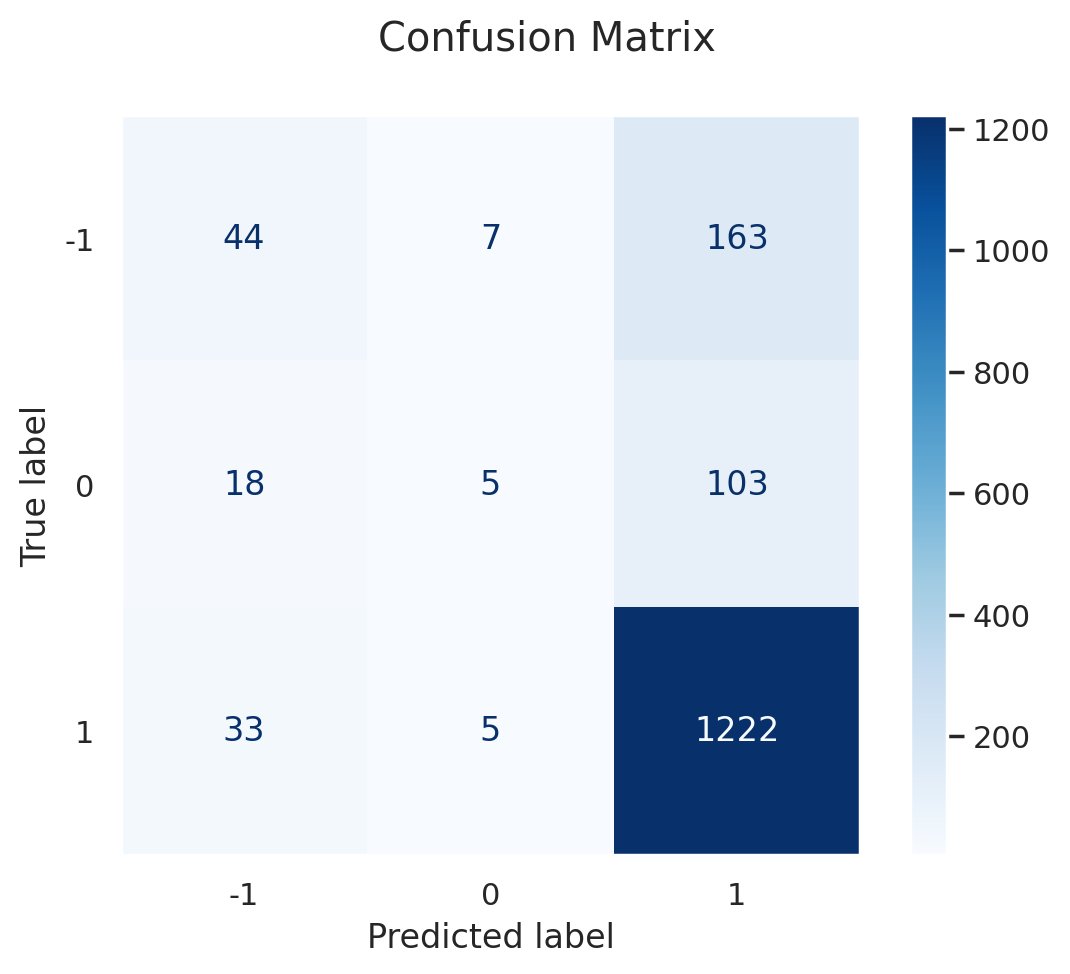

CPU times: user 39.7 s, sys: 3.02 s, total: 42.7 s
Wall time: 24.1 s


In [ ]:
%%time
clf_bert_logistic_stacked = LogisticRegression(
    solver="lbfgs", multi_class="multinomial", max_iter=2000
)
clf_bert_logistic_stacked.fit(train_stacked, y_train_chunks)
evaluate_model(clf_bert_logistic_stacked, valid_stacked, y_valid_chunks)

---

## Part 3: ⏳ BERT fine-tuning

In this part we will fine-tune BERT classifier to improve the performance of the model. Instead of training dedicatede classifier on the extracted features, we apply classification layer on top of BERT. Then, the whole constructed model is fine-tuned, including the BERT weights.  

🚧 To run this code, you **need to use GPU instance** with at least 8GB of memory. Use Kaggle or Colab for free GPU instances. Estimated running time **~2 hours.** 🚧  

You can skip this step, and go directly to the Validation part. Pre-trained weights can be downloaded from the [HERE](https://drive.google.com/drive/folders/1USA00v7G8x1jZqrxsXEPV04vGQCnq8uv?usp=sharing)


### Training part

In [ ]:
from transformers import DataCollatorWithPadding, AutoTokenizer
from transformers import TrainingArguments, Trainer
from transformers import AutoModelForSequenceClassification
from transformers import EarlyStoppingCallback
from imblearn.under_sampling import RandomUnderSampler


In [ ]:
# Extract text and label from the dataframe.
cln_df = train_df[["Text", "sentiment"]].copy()
cln_df.dropna(subset=["Text"], inplace=True)
cln_df.reset_index(drop=True, inplace=True)


In [ ]:
## Split to train and validation sets.
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(
    cln_df.Text,
    cln_df.sentiment,
    test_size=0.2,
    random_state=1,
)
x_train.shape, y_train.shape


((6400,), (6400,))

In [ ]:
# UnderSampling of the x_train and y_train
rus = RandomUnderSampler(
    random_state=0, sampling_strategy={-1: 921, 0: 474, 1: 1562} ## change the data for 2 more classes
)
x_train, y_train = rus.fit_resample(
    np.array(x_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1)
)


(array([ 921.,  474., 1562.]),
 array([-1.        , -0.33333333,  0.33333333,  1.        ]),
 <BarContainer object of 3 artists>)

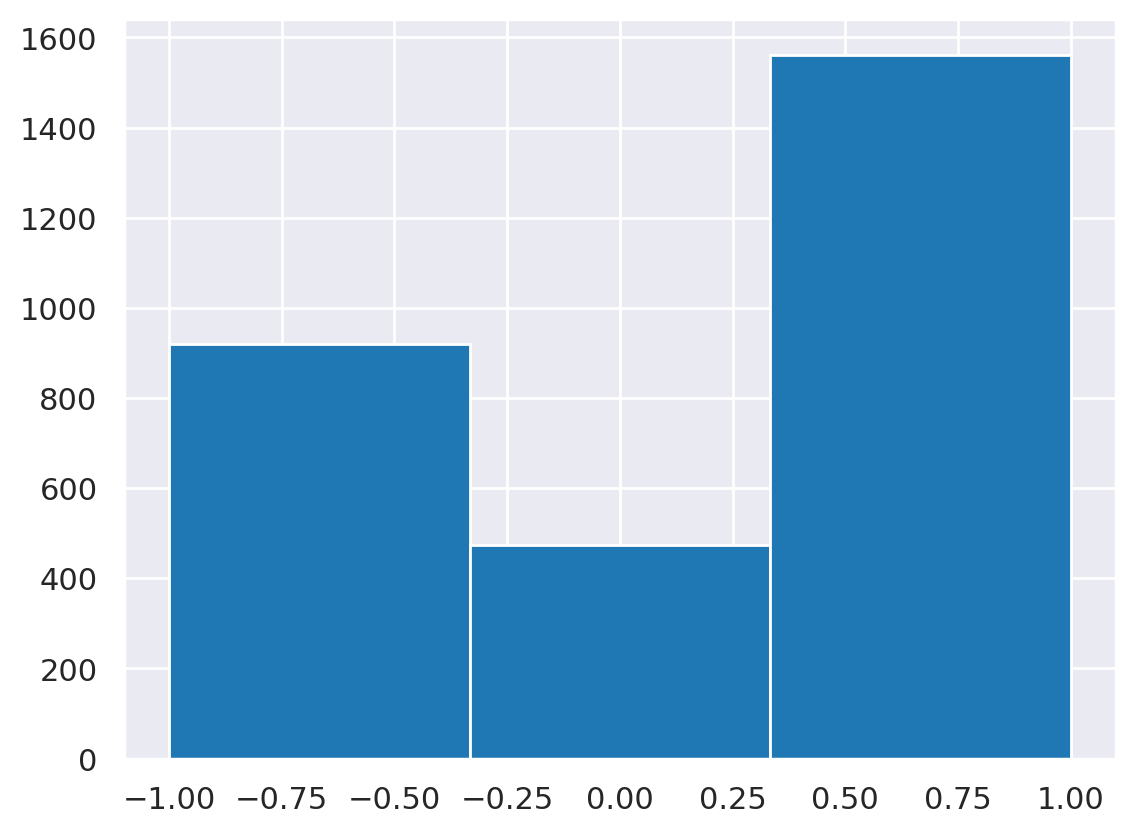

In [ ]:
# plot histogram of y_train
plt.hist(y_train, bins=3)


Here we transform data to list.

In [ ]:
VAL_DATA_DIVIDER = 10

x_train = x_train.reshape(-1).tolist()[:]
x_valid = x_valid.values.tolist()[: len(x_valid) // VAL_DATA_DIVIDER]

y_train = y_train.reshape(-1).tolist()[:]
y_valid = y_valid.values.tolist()[: len(y_valid) // VAL_DATA_DIVIDER]

len(x_train), len(x_valid), len(y_train), len(y_valid)


(2957, 160, 2957, 160)

Initialize BERT Classifier model

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=3
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenize the data

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
x_train_tok = tokenizer(x_train, truncation=True, padding=True, max_length=512)
x_valid_tok = tokenizer(x_valid, truncation=True, padding=True, max_length=512)


Define the class for input Dataset. We need to use it as a loader of data into PyTorch model.  
Also, to track metrics during validation steps, we need to define them as a dedicated function

In [ ]:
# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx] + 1)
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])


train_dataset = Dataset(x_train_tok, y_train)
val_dataset = Dataset(x_valid_tok, y_valid)


In [ ]:
# Validation metrics function
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred, average="macro")
    precision = precision_score(y_true=labels, y_pred=pred, average="macro")
    f1 = f1_score(y_true=labels, y_pred=pred, average="macro")

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}


Finally, we define the training hyperparameters. To simplify training process, we used `Trainer` class from the transormers library.

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    seed=0,
    evaluation_strategy="steps",
    eval_steps=500,
    load_best_model_at_end=True,
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning:

`evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead

<ipython-input-94-5663457c18e2>:15: FutureWarning:

`tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.



In [ ]:
# this code is essential for experiment management and monitoring, which helps improve the workflow of training machine learning models, track progress, and collaborate effectively.
# Login in with personal credentials

from sklearn.metrics import accuracy_score, recall_score, precision_score
import wandb
wandb.login()  # Ensure you're logged in

wandb.init(
    project="programming",  # Set a project name
    entity="alexisma0003-srh-hoschule",  # Replace with your W&B entity (or leave None for personal)
    config=training_args  # Log training arguments
)
# API KEY: e5a0340888325e348b27c61e73c24c83a1f19fb1

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: alexisma0003 (alexisma0003-srh-hoschule) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


⌛️ Finally, run the training process

In [ ]:
trainer.train()


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
500,0.944400,0.727467,0.668750,0.404789,0.502173,0.419580
1000,0.825500,0.599447,0.768750,0.443583,0.537375,0.478610


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



TrainOutput(global_step=1110, training_loss=0.869966256081521, metrics={'train_runtime': 453.8304, 'train_samples_per_second': 19.547, 'train_steps_per_second': 2.446, 'total_flos': 1175139250043904.0, 'train_loss': 0.869966256081521, 'epoch': 3.0})

### Validation part

Load model from saved weights

In [ ]:
!ls /content/results


checkpoint-1000  checkpoint-1110  checkpoint-500  runs


In [ ]:
# Load trained model
model_path = "./results/checkpoint-1000"
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=3)

# Define test trainer
test_trainer = Trainer(model)


Run prediction on validation set

In [ ]:
# Validation data
raw_pred, _, _ = test_trainer.predict(val_dataset)

y_pred = np.argmax(raw_pred, axis=1)


Note! Because fine-tuned model will return classes in the form of probabilities, we need to use `argmax` to get the class label.

Also, these labels will be in [0,1,2] format, so we need to convert them to [-1,0,1] format.

In [ ]:
print(classification_report(y_valid, y_pred - 1))


              precision    recall  f1-score   support

          -1       0.44      0.73      0.55        26
           0       0.00      0.00      0.00        16
           1       0.89      0.88      0.89       118

    accuracy                           0.77       160
   macro avg       0.44      0.54      0.48       160
weighted avg       0.73      0.77      0.74       160



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



---

## Part 3: Evaluation of the main models

In this section we will test the our best findings on the test set and compare the results in the Final table

### Prepare data

In [ ]:
cln_df_test = test_df[["Text", "sentiment"]].copy()
cln_df_test.dropna(subset=["Text"], inplace=True)
cln_df_test.reset_index(drop=True, inplace=True)
cln_df_test.head(3)


,Text,sentiment
0,I should say...my dogs love these! I like the ...,1
1,I have also tried the regular Lowrey's microwa...,1
2,This gluten free pizza is easy to make and has...,1


### Glove embeddings + SGDClassifier

In [ ]:
test_df_copy = test_df.copy()

In [ ]:
test_df_copy["words"] = test_df_copy.Text.str.findall(tokenizer_re)
test_df_copy["embeddings"] = test_df_copy.words.progress_map(vectorize_sentence_bow)
test_df_copy.dropna(inplace=True)

NameError: name 'tokenizer_re' is not defined

In [ ]:
evaluate_model(sgd_glove, np.stack(test_df_copy['embeddings']), test_df_copy['sentiment'])

### 1. BERT embeddings + SGDClassifier

Load pre-calculated features

In [ ]:
test_features = np.load("./test_features.npy")
test_features = test_features.reshape(test_features.shape[0], -1)


In [ ]:
preds = clf_bert_sgd.predict(test_features)
print(classification_report(y_test, preds))
print("F1 score: ", f1_score(y_test, preds, average="macro"))


### 2. BERT embeddings + LogisticRegression + Stacked features

In [ ]:
cln_test = test_df[["Summary","Text", "sentiment"]].copy()
cln_test['test_features'] = test_features.tolist()
cln_test.dropna(subset=["Summary","Text"], inplace=True)
cln_test.reset_index(drop=True, inplace=True)
test_features_cln = np.array([np.array(xi) for xi in cln_test['test_features'].to_numpy()])
test_stacked = np.concatenate([test_features_summary,test_features_cln],axis=1)

In [ ]:
evaluate_model(clf_bert_logistic_stacked, test_stacked, cln_test.sentiment)

### 2. Fine-tuned BERT

In [ ]:
x_test = cln_df_test.Text.values.tolist()
y_test = cln_df_test.sentiment.values.tolist()


In [ ]:
x_test_tok = tokenizer(x_test, padding=True, truncation=True, max_length=512)

# Create torch dataset
test_dataset = Dataset(x_test_tok)


In [ ]:
# Make prediction
raw_pred, _, _ = test_trainer.predict(test_dataset)

# Preprocess raw predictions
y_pred = np.argmax(raw_pred, axis=1)


In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print(classification_report(y_test, y_pred - 1))

disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred - 1, cmap=plt.cm.Blues)

disp.figure_.suptitle("Confusion Matrix")
plt.grid(False)
plt.show()




### Table of results





| Method                                      | F1 Macro Avg |
|---------------------------------------------|-------------|
| Baseline model with counting based vectorization | 0.56        |
| TFIDF SGDC classifier                       | 0.45        |
| GloVe embeddings SGDC                       | 0.48        |
| BERT                                        | 0.59        |
| BERT + SGDC                                 | 0.60        |
| BERT + PCA + Random Forest                  | 0.40        |
| BERT + Stack + Logistic                     | 0.40        |
| BERT + Fine Tuning                          | 0.52        |



